In [3]:
!pip install -U 'spacy[cuda-autodetect]'

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 MB 9.3 MB/s eta 0:00:00
  Created wheel for cupy-wheel: filename=cupy_wheel-12.3.0-py3-none-any.whl size=993 sha256=cb5748b144c9e28e33cbb1e852b3acb5de8f433342f1da72897933abf12ffabd
  Stored in directory: /root/.cache/pip/wheels/e5/f3/9d/f049ae6f63a76342d52b752cfe2eabd7b96dcc363506bb00fa
Successfully built cupy-wheel
  Attempting uninstall: cupy-cuda12x
    Found existing installation: cupy-cuda12x 12.2.0
    Uninstalling cupy-cuda12x-12.2.0:
      Successfully uninstalled cupy-cuda12x-12.2.0


In [4]:
!python -m spacy download en_core_web_sm
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 22.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 14.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


### 1. Load data

In [15]:
import pandas as pd
import numpy as np

df_resume = pd.read_csv("/content/UpdatedResumeDataSet.csv")

In [16]:
df_resume = df_resume.reindex(np.random.permutation(df_resume.index))
df_resume = df_resume.copy().iloc[:1000, ]
df_resume.shape

(962, 2)

### 2. Load skill data

If we define patterns for all the skill, we gonna be too tired.

So spacy knows that, so it allows you to give you a list of words, then it will automatically create pattern.

In [17]:
import spacy

nlp = spacy.load('en_core_web_md')
skill_path = "/content/skills.jsonl"

In [18]:
ruler = nlp.add_pipe("entity_ruler")
ruler.from_disk(skill_path)
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'entity_ruler']

In [19]:
doc = nlp("Chaky loves deep learning.")
doc.ents

(Chaky, deep learning)

### 3. Let's try to extract skills from this resume.csv

In [20]:
df_resume.head()

,Category,Resume
41,HR,"I.T. Skills â¢ Windows XP, Ms Office (Word, E..."
509,Electrical Engineering,Education Details \r\nJuly 2016 to May 2019 BE...
422,Business Analyst,Education Details \r\nFebruary 2006 to Februar...
658,Network Security Engineer,"Operating Systems: Windows, Linux, Ubuntu Netw..."
491,Electrical Engineering,Skills: 1) MC Office 2) AutoCAD 2016 3) Introd...


In [21]:
from spacy.lang.en.stop_words import STOP_WORDS

def preprocessing(sentence):

    stopwords = list(STOP_WORDS)
    doc = nlp(sentence)
    cleaned_tokens = []

    for token in doc:
        if token.text not in stopwords and token.pos_ != 'PUNCT' and token.pos_ != 'SPACE' and \
            token.pos_ != 'SYM':
                cleaned_tokens.append(token.lemma_.lower().strip())

    return " ".join(cleaned_tokens)

In [23]:
random_resume = df_resume.Resume.iloc[5]
random_resume[:300]

'Expertise â\x88\x92 Data and Quantitative Analysis â\x88\x92 Decision Analytics â\x88\x92 Predictive Modeling â\x88\x92 Data-Driven Personalization â\x88\x92 KPI Dashboards â\x88\x92 Big Data Queries and Interpretation â\x88\x92 Data Mining and Visualization Tools â\x88\x92 Machine Learning Algorithms â\x88\x92 Business Intelligence (BI) â\x88\x92 Research, '

In [24]:
preprocessing(random_resume[:300])

'expertise â\x88\x92 datum quantitative analysis decision analytics predictive modeling data drive personalization kpi dashboard big data queries interpretation data mining visualization tools machine learn algorithms â\x88\x92 business intelligence bi research'

In [26]:
for i, row in df_resume.iterrows():
    clean_text = preprocessing(row.Resume)
    df_resume.at[i, 'Clean_resume'] = clean_text

In [27]:
df_resume.head()

,Category,Resume,Clean_resume
41,HR,"I.T. Skills â¢ Windows XP, Ms Office (Word, E...",i.t. skill â¢ windows xp ms office word excel...
509,Electrical Engineering,Education Details \r\nJuly 2016 to May 2019 BE...,education details july 2016 may 2019 be electr...
422,Business Analyst,Education Details \r\nFebruary 2006 to Februar...,education details february 2006 february 2006 ...
658,Network Security Engineer,"Operating Systems: Windows, Linux, Ubuntu Netw...",operating systems windows linux ubuntu network...
491,Electrical Engineering,Skills: 1) MC Office 2) AutoCAD 2016 3) Introd...,skill 1 mc office 2 autocad 2016 3 introductor...


### 4. Let's really extract skills!!

In [28]:
def get_skills(text):
    #pass the text to the nlp
    doc = nlp(text)  #note that this nlp already know skills

    skills = []

    #look at the ents
    for ent in doc.ents:
        #if the ent.label_ is SKILL, then we append to some list
        if ent.label_ == "SKILL":
            skills.append(ent.text)

    return skills

def unique_skills(x):
    return list(set(x))

In [29]:
df_resume.head(1)

,Category,Resume,Clean_resume
41,HR,"I.T. Skills â¢ Windows XP, Ms Office (Word, E...",i.t. skill â¢ windows xp ms office word excel...


In [30]:
df_resume['Skills'] = df_resume.Clean_resume.apply(get_skills)
df_resume['Skills'] = df_resume.Skills.apply(unique_skills)

In [31]:
df_resume.Skills.iloc[0]

['deployment', 'software', 'windows', 'schedule']

### 5. Visualization

Which skills is most important in information management?

In [35]:
set(df_resume.Category)

{'Advocate',
 'Arts',
 'Automation Testing',
 'Blockchain',
 'Business Analyst',
 'Civil Engineer',
 'Data Science',
 'Database',
 'DevOps Engineer',
 'DotNet Developer',
 'ETL Developer',
 'Electrical Engineering',
 'HR',
 'Hadoop',
 'Health and fitness',
 'Java Developer',
 'Mechanical Engineer',
 'Network Security Engineer',
 'Operations Manager',
 'PMO',
 'Python Developer',
 'SAP Developer',
 'Sales',
 'Testing',
 'Web Designing'}

In [36]:
category = 'Web Designing'
cond = df_resume.Category == category

df_resume_it = df_resume[cond]
df_resume_it.shape

(45, 4)

In [37]:
all_skill = np.concatenate(df_resume_it.Skills.values)

In [38]:
from collections import Counter, OrderedDict

counting = Counter(all_skill)
counting = OrderedDict(counting.most_common(10))

In [39]:
counting

OrderedDict([('bootstrap', 36),
             ('javascript', 36),
             ('jquery', 36),
             ('software', 36),
             ('design', 36),
             ('brackets', 18),
             ('security', 18),
             ('web app', 18),
             ('support', 18),
             ('sass', 18)])

<BarContainer object of 10 artists>

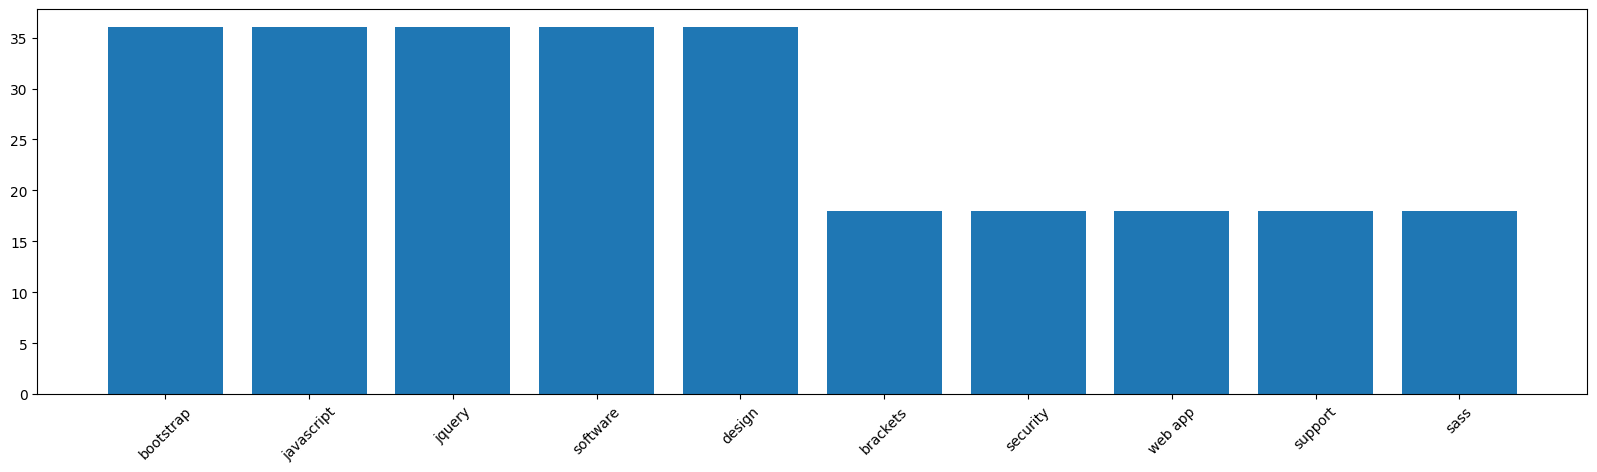

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 5))
plt.xticks(rotation =45)

plt.bar(counting.keys(), counting.values())

### 6. Name Entity Recognition

In [41]:
from spacy import displacy

text = df_resume_it.Clean_resume.iloc[43]

In [42]:
doc = nlp(text)

In [43]:
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'entity_ruler']

In [44]:
colors = {"SKILL": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
options = {"colors": colors}

displacy.render(doc, style="ent", options=options)

'<div class="entities" style="line-height: 2.5; direction: ltr">technical skills web technologies \n<mark class="entity" style="background: linear-gradient(90deg, #aa9cfc, #fc9ce7); padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">\n    angular\n    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">SKILL</span>\n</mark>\n js html5 css3 \n<mark class="entity" style="background: linear-gradient(90deg, #aa9cfc, #fc9ce7); padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">\n    sass\n    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">SKILL</span>\n</mark>\n \n<mark class="entity" style="background: linear-gradient(90deg, #aa9cfc, #fc9ce7); padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">\n    bootstrap\n    <span style="font-siz

### 7. Let's load the PDF - add some realism

In [45]:
!pip install PyPDF2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 4.3 MB/s eta 0:00:00


In [46]:
from PyPDF2 import PdfReader


reader = PdfReader("/content/aa_cv.pdf")
page = reader.pages[0]
text = page.extract_text()

In [47]:
text = preprocessing(text)

In [48]:
doc = nlp(text)

In [49]:
colors = {"SKILL": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
options = {"colors": colors}

displacy.render(doc, style="ent", options=options)

'<div class="entities" style="line-height: 2.5; direction: ltr">alekhya \n<mark class="entity" style="background: #e4e7d2; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">\n    515\n    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">CARDINAL</span>\n</mark>\n -518 \n<mark class="entity" style="background: #bfe1d9; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">\n    0849\n    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">DATE</span>\n</mark>\n alekhya.workmail @gmail.com professional experience have \n<mark class="entity" style="background: #bfe1d9; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">\n    8 year\n    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align

In [50]:
skills = []

for ent in doc.ents:
    if ent.label_ == 'SKILL':
        skills.append(ent.text)

print(set(skills))

{'security', 'ajax', 'software', 'hibernate', 'design', 'mongodb', 'git', 'angular', 'libraries', 'spring', 'deployment', 'database', 'amazon web services', 'junit', 'nosql', 'server', 'framework', 'spring boot', 'gradle', 'shell', 'java', 'bootstrap', 'application server', 'eclipse', 'web service', 'linux', 'jquery', 'business'}


In [51]:
import csv

field_names = ['No', 'Company']

label = []
resume_dct = {}
for ent in doc.ents:
    if ent.label_ not in label:
        label.append(ent.label_)
        resume_dct[ent.label_] = []
        resume_dct[ent.label_].append(ent.text)
    else:
        resume_dct[ent.label_].append(ent.text)
print(resume_dct)
row = []
with open('resume_hw.csv', 'w+') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames = label)
    writer.writeheader()
    for key in label:
        for val in resume_dct[key]:
            row.append({key:val})
    writer.writerows(row)
df_resume = pd.read_csv('resume_hw.csv')
df_resume = df_resume.apply(lambda x : sorted(x,key=pd.isnull))
df_resume.to_csv('resume_hw.csv')
df_resume.head()

{'CARDINAL': ['515', '3', '8'], 'DATE': ['0849', '8 year', 'spring', 'spring'], 'SKILL': ['software', 'design', 'java', 'server', 'jquery', 'ajax', 'angular', 'bootstrap', 'libraries', 'framework', 'spring', 'spring', 'spring', 'spring', 'security', 'spring boot', 'spring', 'hibernate', 'hibernate', 'java', 'amazon web services', 'amazon web services', 'java', 'spring', 'design', 'business', 'design', 'framework', 'server', 'java', 'web service', 'java', 'java', 'java', 'database', 'java', 'design', 'java', 'hibernate', 'nosql', 'database', 'mongodb', 'gradle', 'deployment', 'eclipse', 'spring', 'deployment', 'application server', 'junit', 'linux', 'shell', 'deployment', 'server', 'git'], 'PERSON': ['amazon rds', 'jta jpa hibernate', 'xpath xforms'], 'ORG': ['sqs', 'sax dom'], 'GPE': ['jax', 'jaxb jax', 'technology jersey', 'xslt'], 'PRODUCT': ['maven', 'apache'], 'NORP': ['glassfish', 'jboss']}


,CARDINAL,DATE,SKILL,PERSON,ORG,GPE,PRODUCT,NORP
0,515.0,0849,software,amazon rds,sqs,jax,maven,glassfish
1,3.0,8 year,design,jta jpa hibernate,sax dom,jaxb jax,apache,jboss
2,8.0,spring,java,xpath xforms,NaN,technology jersey,NaN,NaN
3,NaN,spring,server,NaN,NaN,xslt,NaN,NaN
4,NaN,NaN,jquery,NaN,NaN,NaN,NaN,NaN
